# VAE Reconstruction Quality
This is to check the reconstruction quality of the trained VAE

In [1]:
import scripts.init_gpu as init_gpu
import scripts.init_dataset as init_dataset
from scripts.triplet_functions import n_neurons
import pandas as pd
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

init_gpu.initialize_gpus()

locations = ['LOC2', 'LOC3']

print("Loading Dataset...")
# load the dataset
df = pd.read_csv(
    f"../dataset/processed/{locations[0]}-{locations[1]}-scaled-balanced.csv")

length = len(df.columns) - 2  # subtract the two label columns

# get train-test set
train_df, test_df, train_web_samples, test_web_samples = init_dataset.get_sample(
    df, locations, range(1500), 1200)

train_df.head()

2024-12-04 17:11:37.678593: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 17:11:37.685830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733292697.694159  519210 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733292697.696616  519210 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 17:11:37.705313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1
Loading Dataset...
Training Websites: [1309, 228, 51, 563, 501, 457, 285, 209, 1385, 1116, 178, 1209, 864, 65, 61, 191, 447, 476, 1034, 1232, 54, 1149, 407, 1466, 1330, 1436, 1490, 859, 451, 919, 1206, 569, 13, 326, 1429, 865, 696, 1468, 318, 440, 689, 1492, 189, 778, 198, 735, 704, 1236, 541, 88, 940, 1098, 255, 775, 161, 1130, 600, 1287, 1266, 740, 1182, 393, 142, 93, 1354, 466, 592, 163, 1482, 206, 1456, 1462, 928, 1301, 747, 333, 758, 727, 429, 1372, 546, 1399, 1327, 146, 1247, 1300, 350, 1093, 1495, 334, 946, 777, 552, 1310, 1140, 449, 1402, 664, 114, 469, 1486, 646, 821, 548, 135, 432, 1161, 644, 435, 1342, 1022, 810, 1316, 939, 292, 542, 1493, 505, 1478, 1103, 538, 1197, 877, 1195, 817, 741, 1404, 283, 1043, 1010, 186, 96, 224, 313, 1285, 327, 1487, 1221, 130, 788, 781, 1220, 958, 1083, 514, 1133, 23, 234, 1099, 1419, 1312, 1463, 1498, 601, 890, 323, 929, 6, 539, 1025, 365, 1039, 217, 1280, 611, 1308, 1338, 1415, 1477, 1366, 765, 330, 1104, 1086, 1, 1226, 

/home/asil0892/doh_traffic_analysis/code/scripts/init_dataset.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by=["Location"], inplace=True)


,Location,Website,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
0,LOC2,0,-0.714089,0.541197,0.391921,-0.400778,-0.266345,-0.522526,0.023889,-0.261817,...,0.125986,0.10277,0.092495,0.043004,0.158904,0.119506,0.099445,0.083843,0.037226,0.152216
1,LOC2,1006,0.093792,-1.273349,-2.142801,1.205098,1.879002,2.139593,1.482513,2.382939,...,0.125986,0.10277,0.092495,0.043004,0.158904,0.119506,0.099445,0.083843,0.037226,0.152216
2,LOC2,1006,1.401091,-1.636258,0.527106,0.354928,-0.017609,-0.049260,-0.177300,-0.412692,...,0.125986,0.10277,0.092495,0.043004,0.158904,0.119506,0.099445,0.083843,0.037226,0.152216
3,LOC2,1006,-0.831599,0.662167,0.527106,0.354928,-0.017609,-0.049260,-0.177300,-0.412692,...,0.125986,0.10277,0.092495,0.043004,0.158904,0.119506,0.099445,0.083843,0.037226,0.152216
4,LOC2,1006,0.093792,-1.152379,-2.007616,0.827245,1.630266,1.666328,1.281324,2.311938,...,0.125986,0.10277,0.092495,0.043004,0.158904,0.119506,0.099445,0.083843,0.037226,0.152216


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from scripts.train_vae import Sampling, VAE, vae_loss, train_vae, filter_and_sort_data

def vae_loss(inputs, reconstructed, z_mean, z_log_var):
    mse_loss = tf.reduce_mean(tf.square(inputs - reconstructed))
    kl_loss = -0.5 * \
        tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    total_loss = mse_loss + 0. * kl_loss
    return total_loss

def prepare_data(train_df, test_df, input_location, output_location):
    x_train = filter_and_sort_data(train_df, input_location).to_numpy()
    y_train = filter_and_sort_data(train_df, output_location).to_numpy()
    
    x_test =  filter_and_sort_data(test_df, input_location).to_numpy()
    y_test =  filter_and_sort_data(test_df, output_location).to_numpy()
    
    return x_train.astype(np.float32), y_train.astype(np.float32), x_test.astype(np.float32), y_test.astype(np.float32)

In [3]:
location = 'LOC3'
# x_train = filter_and_sort_data(
#         train_df, location).to_numpy().astype(np.float32)

x_test = filter_and_sort_data(test_df, location).to_numpy().astype(np.float32)

# Create TensorFlow dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train)).batch(128)

In [15]:
from scripts.train_vae import ConvVAE_BatchNorm
vae_model = tf.keras.models.load_model(f"../models-{locations[0]}-{locations[1]}/vae/ci_vae/ConvBased/domain_and_class/{locations[0]}-{locations[1]}-e800-mse1-kl0.01-cl1.0-ConvBatchNorm-ldim96-hdim128.keras", custom_objects={'ConvVAE_BatchNorm': ConvVAE_BatchNorm, 'Sampling': Sampling})


/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [16]:
def get_reconstructions(data, vae_model):
    embeddings = []
    chunk_size = 200
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i+chunk_size]
        transformed_chunk, _, _ = vae_model(chunk)
        embeddings.append(transformed_chunk)

    return np.vstack(embeddings)

reconstructed = get_reconstructions(x_test, vae_model)

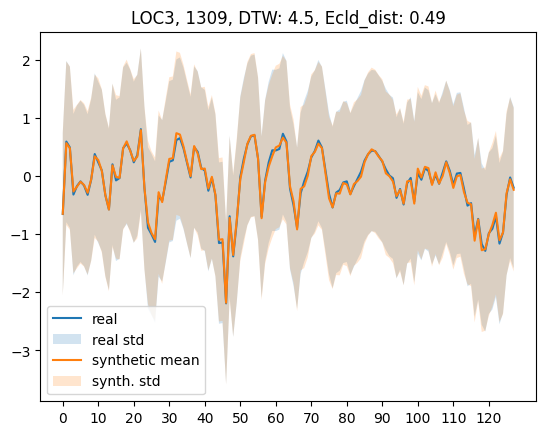

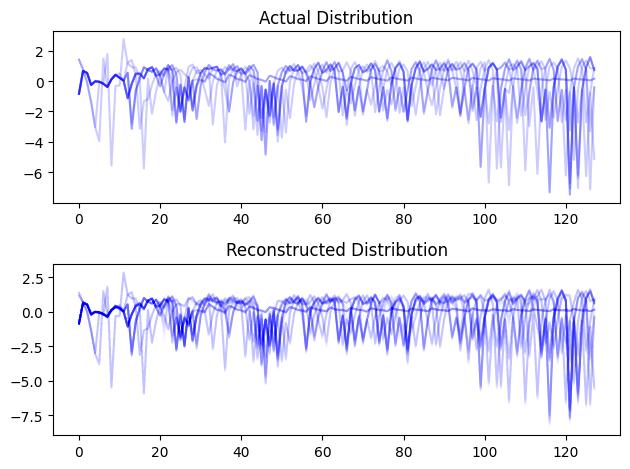

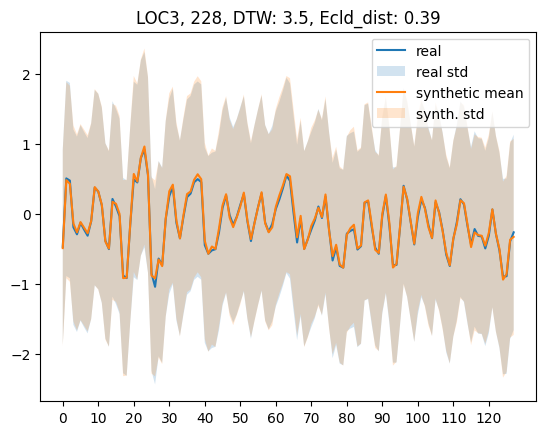

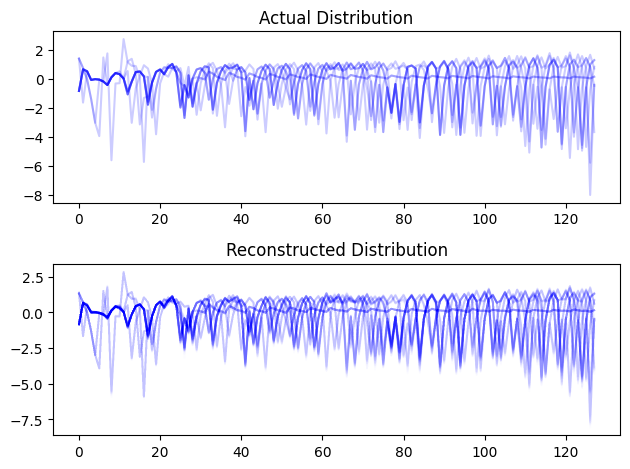

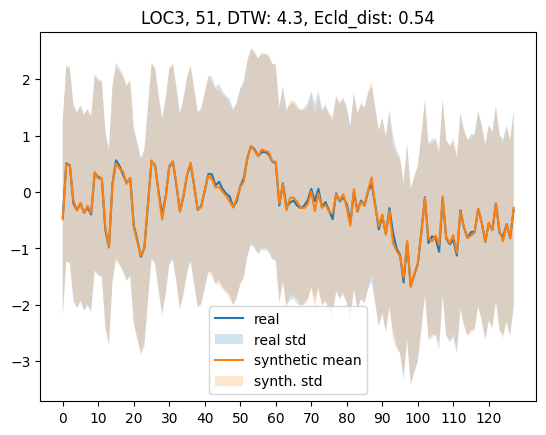

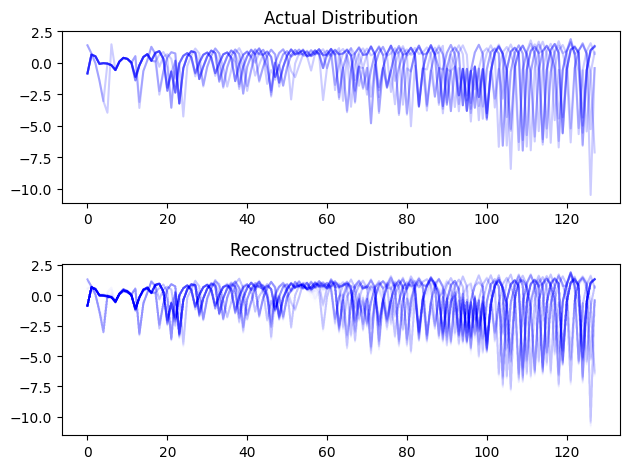

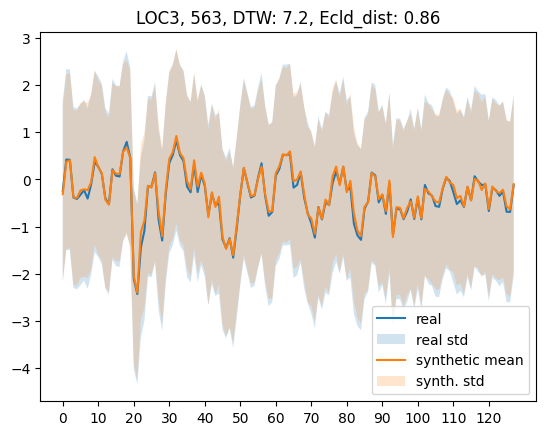

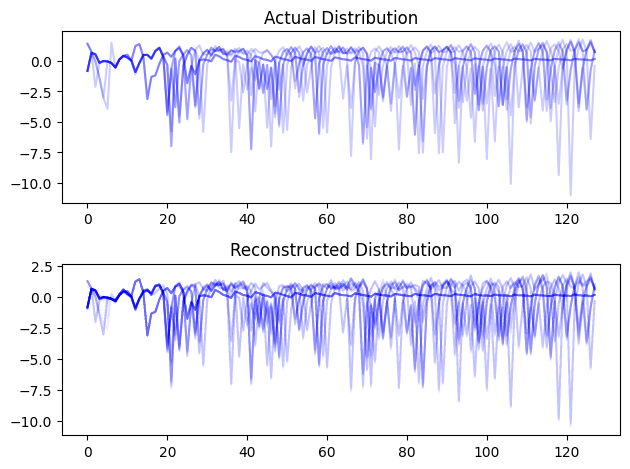

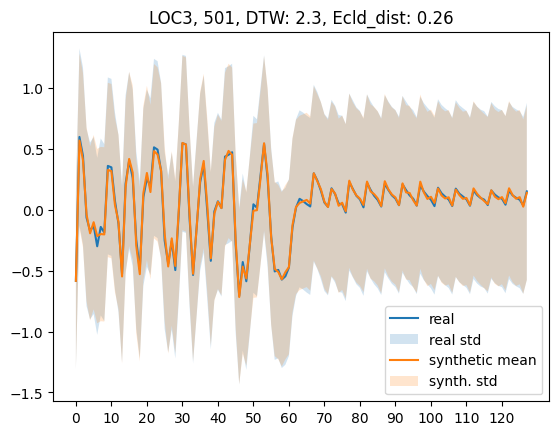

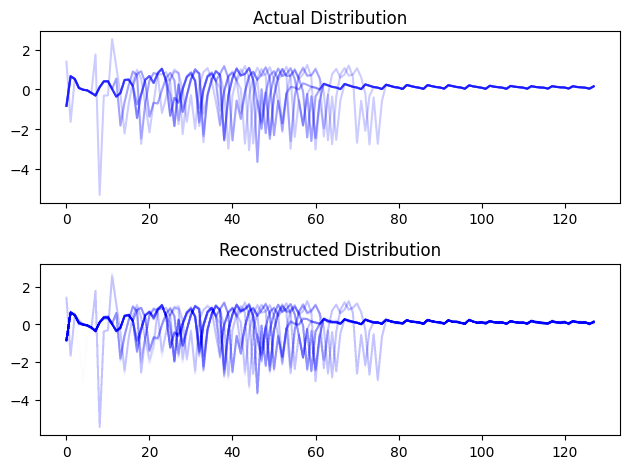

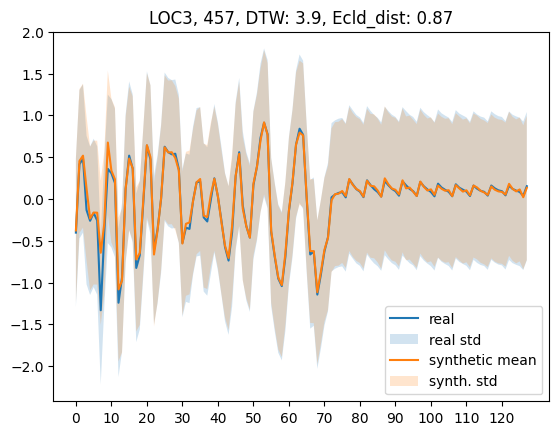

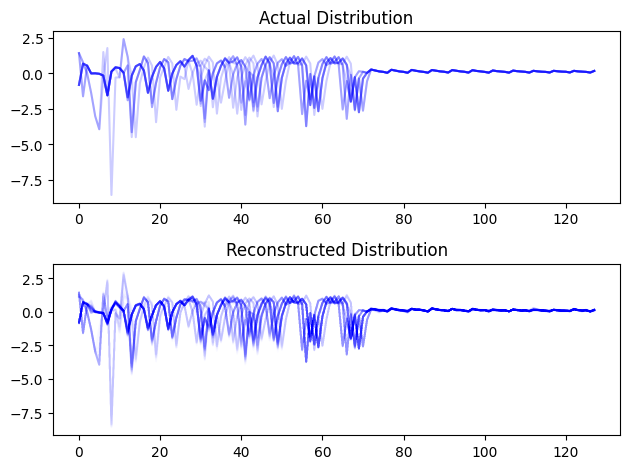

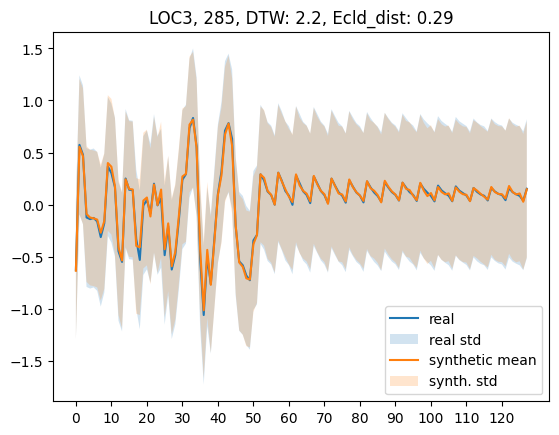

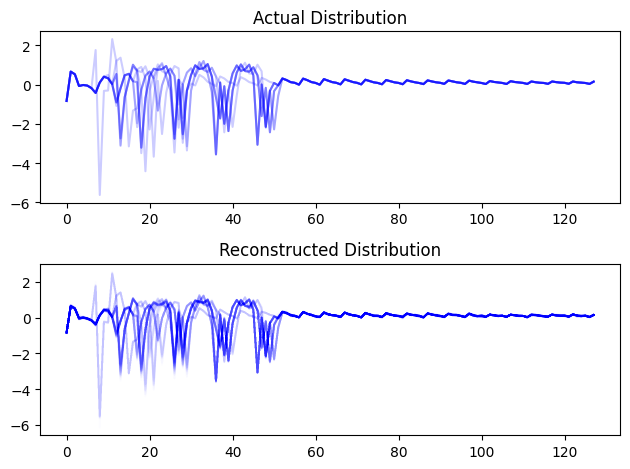

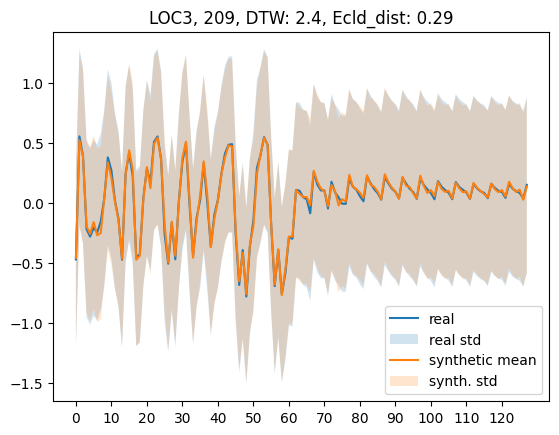

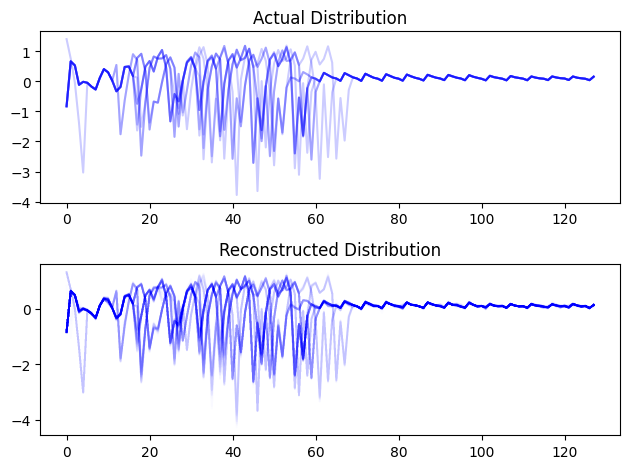

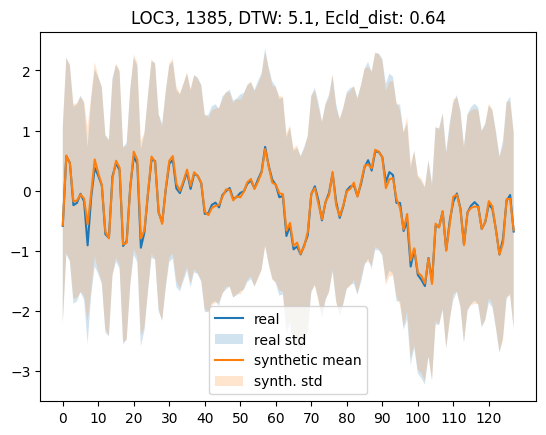

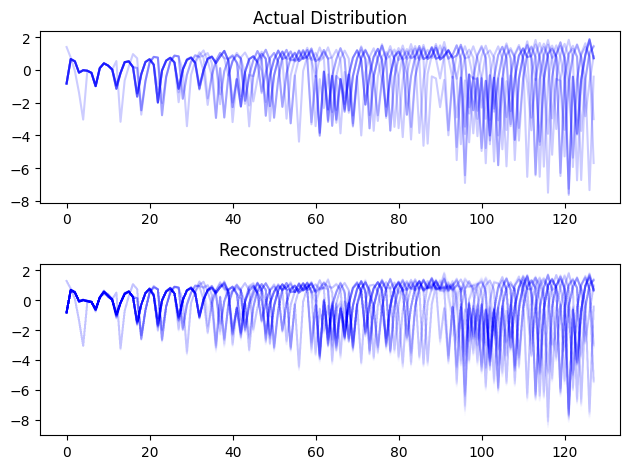

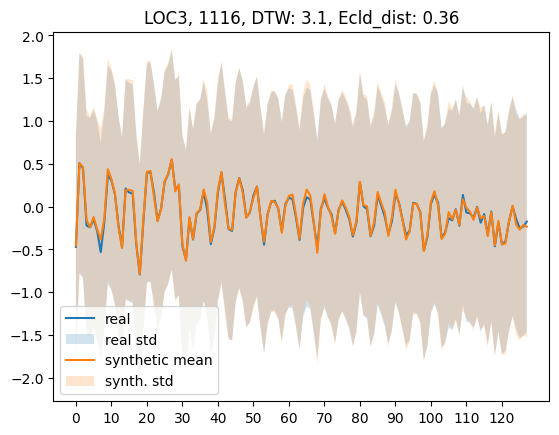

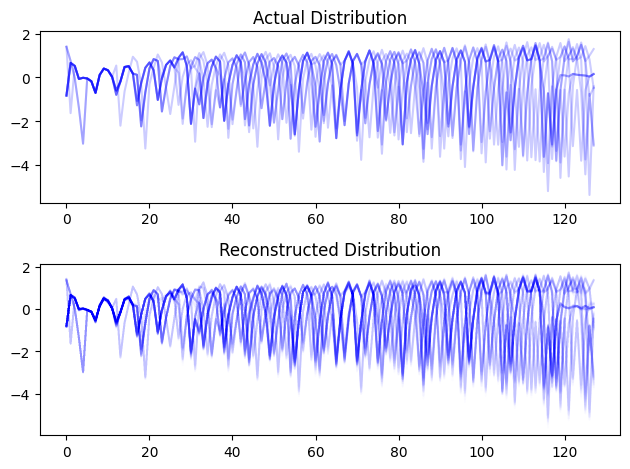

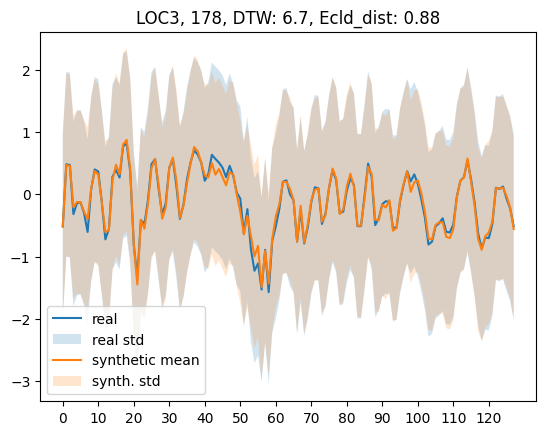

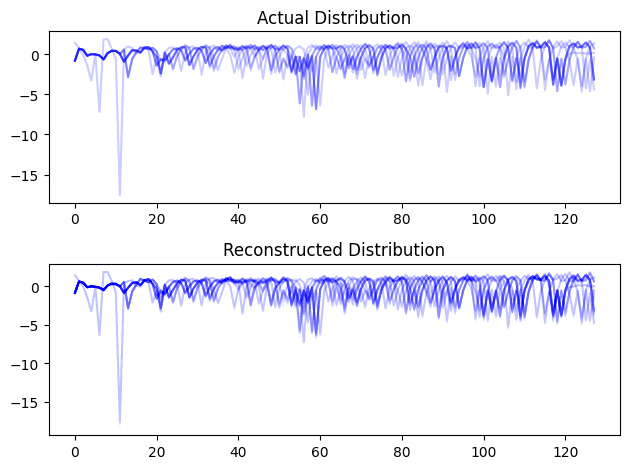

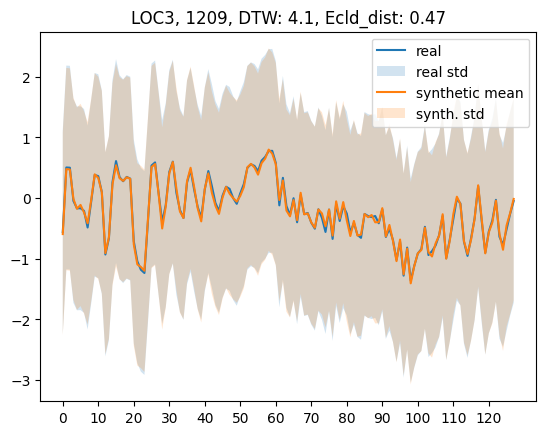

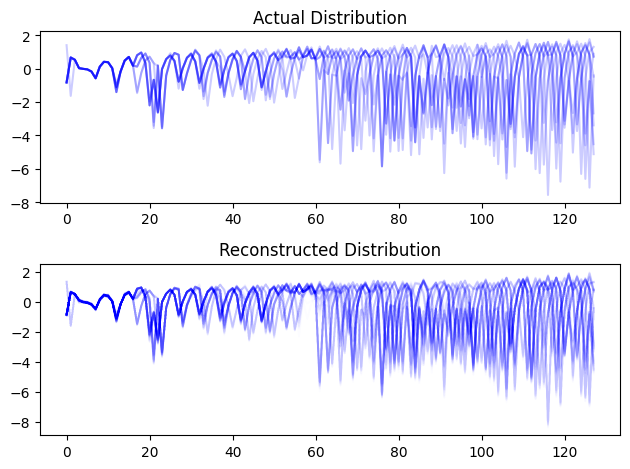

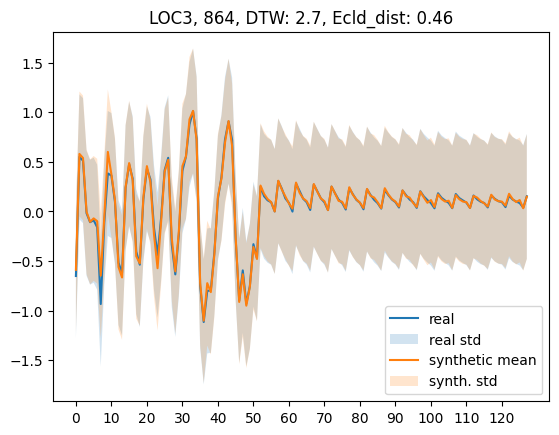

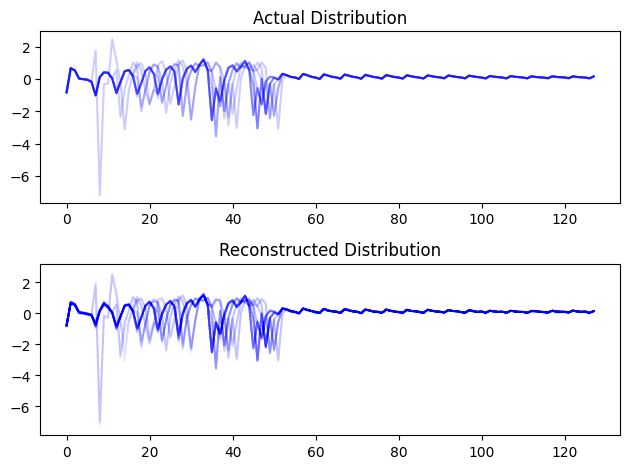

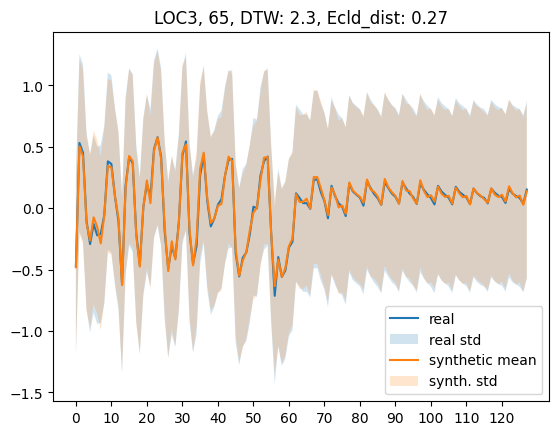

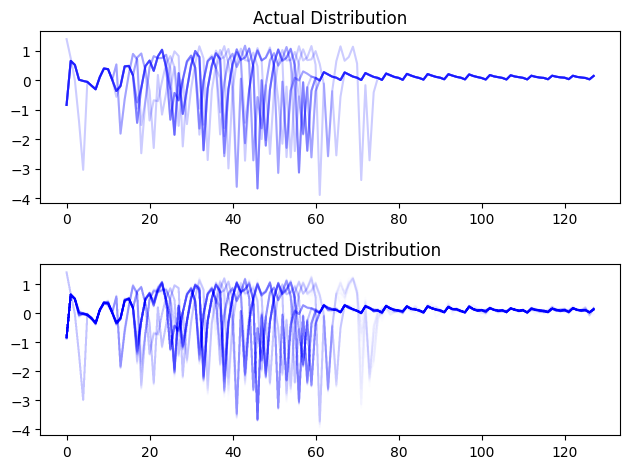

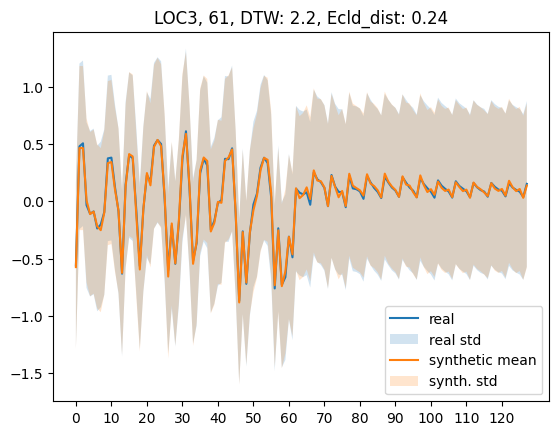

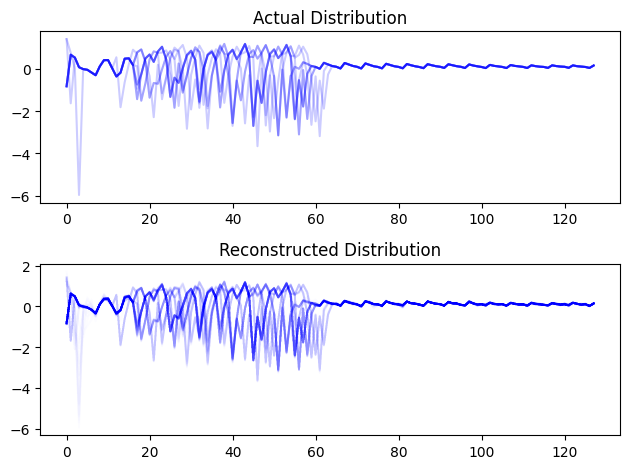

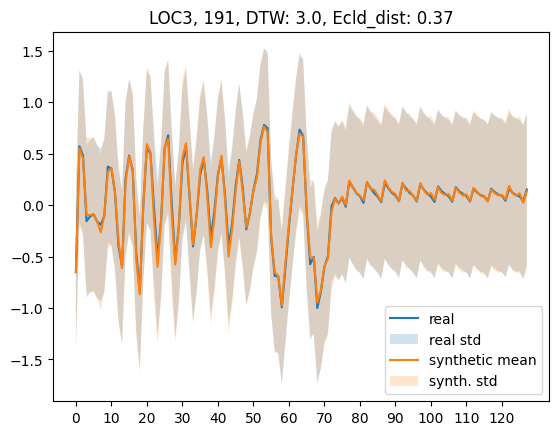

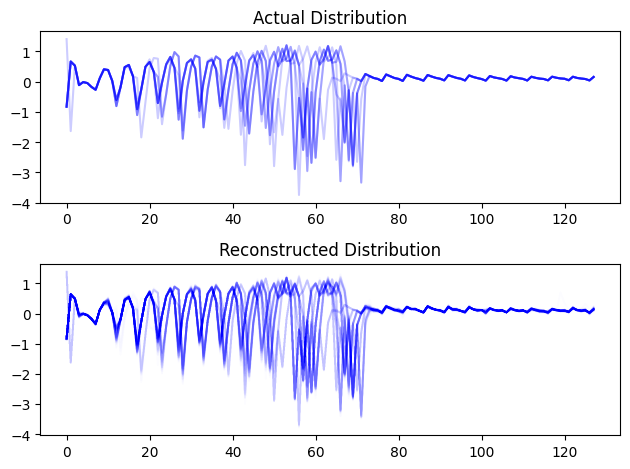

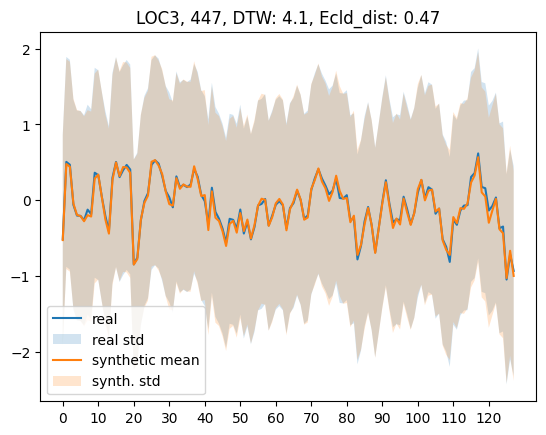

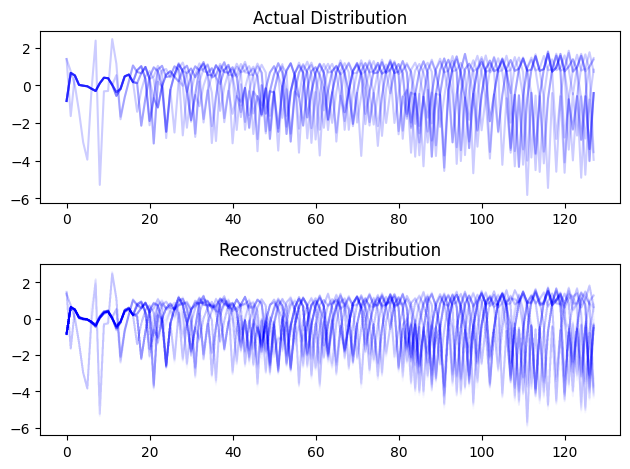

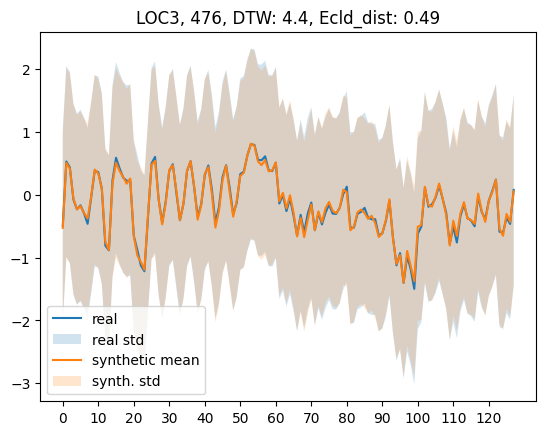

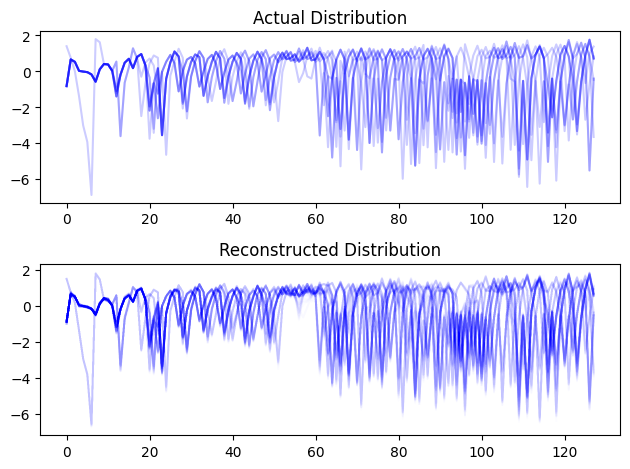

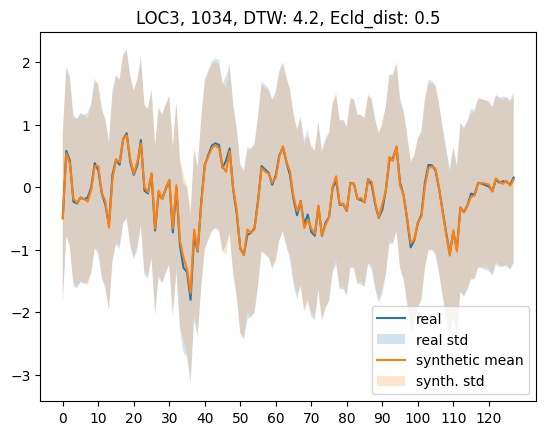

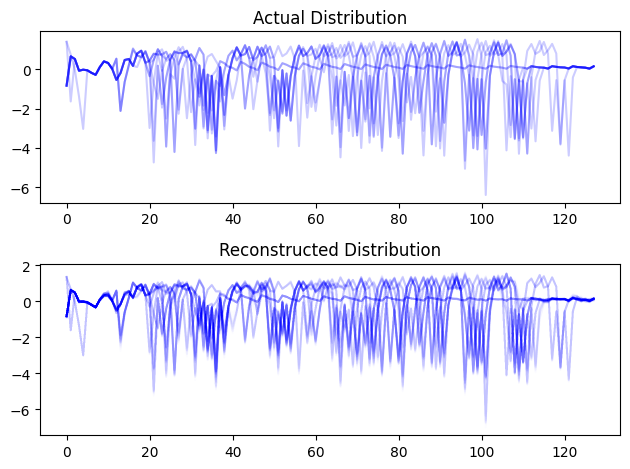

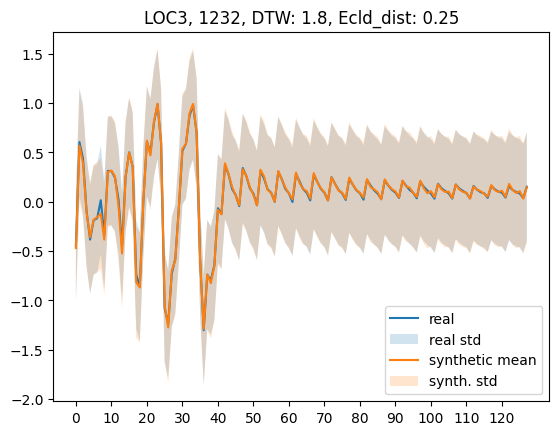

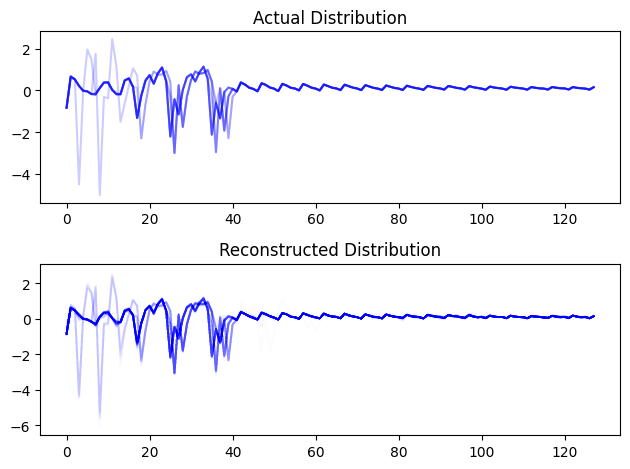

9.41613757610321


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from fastdtw import fastdtw

import numpy as np
def get_euclidean_distance(a, b):
    return np.sqrt(np.sum(np.square(a - b)))

samples_per_website = 99

eucld_dists = []
for i in range(0, 20 * samples_per_website, samples_per_website):
    plt.figure()
    # real mean
    real_mean = np.mean(x_test[i:i+samples_per_website], axis=0)
    real_std = np.std(x_test[i:i+samples_per_website])
    
    plt.plot(real_mean, label='real')
    plt.fill_between(range(length),real_mean + real_std, real_mean - real_std, label='real std', alpha = 0.2)
    
    # synth mean
    synthetic_mean = np.mean(reconstructed[i:i+samples_per_website], axis=0)
    synthetic_std = np.std(reconstructed[i:i+samples_per_website])
    
    dtw_distance, path = fastdtw(real_mean, synthetic_mean, dist=get_euclidean_distance)
    euclidean_distance = get_euclidean_distance(real_mean, synthetic_mean)

    plt.plot(synthetic_mean, label='synthetic mean')
    plt.fill_between(range(length), synthetic_mean + synthetic_std, synthetic_mean - synthetic_std, label='synth. std', alpha = 0.2)
    
    
    plt.xticks(range(0,length, 10), labels=range(0, length, 10))
    plt.title(f"{location}, {train_web_samples[i // samples_per_website]}, DTW: {dtw_distance:.2}, Ecld_dist: {euclidean_distance:.2}")
    plt.legend()
    plt.show()
    plt.close()

    plt.figure()
    plt.subplot(2, 1, 1)
    for j in range(10):
        plt.plot(x_test[i + j], alpha = 0.2, c = 'b')
    plt.title("Actual Distribution")
    
    plt.subplot(2, 1, 2)
    for j in range(10):
        for k in range(20):
            reconstructions_from_single_trace, _, _ = vae_model(x_test[i + j].reshape(1, -1))
            plt.plot(reconstructions_from_single_trace[0], alpha = 0.01, c = 'b')
    plt.title("Reconstructed Distribution")
    plt.tight_layout()
    plt.show()
    plt.close()
        
    
    eucld_dists.append(euclidean_distance)
    

print(sum(eucld_dists))